In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utilities import train_test_val_split, rmse, load_matlab_data
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
matlab_data = loadmat("data/hwk8data.mat")
print(matlab_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'data', 'test1', 'test2'])


In [3]:
data = matlab_data['data']
test1 = matlab_data['test1']
test2 = matlab_data['test2']

In [4]:
print(data.shape)

(450, 21)


Briefly describe PCA and how it is used for anomaly detection. Describe the use of Q- and T2-statistics for detecting anomalies. Give the equations for calculating the Q- and T2-statistics.

In [5]:
def t2(data, pca):
    """Calculate the T^2 score for a data sample
    """
    l = np.diag(pca.explained_variance_)
    t = pca.transform(data)
    return np.array([tt @ l @ tt.T for tt in t])

In [6]:
def q(data, pca):
    """Calculate Q-score for a data sample
    """
    # Get dimensionality of the data
    i = data.shape[1]
    
    pp = pca.components_.T @ pca.components_
    
    return np.array([x @ (np.eye(i) - pp) @ x.T for x in data])

Develop a PCA model of the normal operating data contained in data.

In [7]:
scale = StandardScaler().fit(data)

In [8]:
data_s = scale.transform(data)

In [9]:
pca = PCA().fit(data_s)

In [10]:
test1_s = scale.transform(test1)
test2_s = scale.transform(test2)

Determine on your own how many PCs should be included in the model.

Calculate the number of components required to explain 95% of the variance

In [11]:
np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)

(array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),)

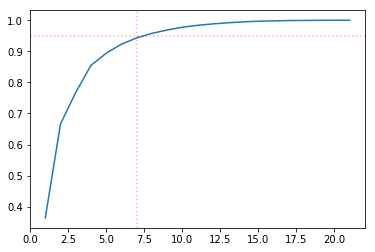

In [12]:
plt.plot(range(1, pca.explained_variance_.shape[0]+1), np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, color='r', linestyle=':', alpha=0.3)
plt.axvline(x=7, color='r', linestyle=':', alpha=0.3)

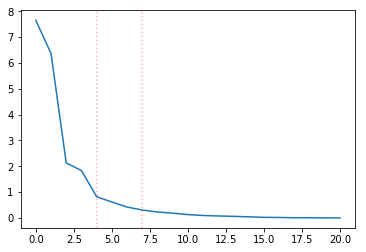

In [13]:
plt.plot(pca.explained_variance_)
plt.axvline(x=4, color='r', linestyle=':', alpha=0.3)
plt.axvline(x=7, color='r', linestyle=':', alpha=0.3)

In [14]:
np.sum(pca.explained_variance_ratio_[:5])

0.8937052870565831

Calculate the norm of the residuals as a percentage of the norm of the scaled training data

In [15]:
e = []
for i in range(1, data.shape[1]):
    pc = PCA(n_components=i).fit(data_s)
    p = pc.inverse_transform(pc.transform(data_s))
    res = la.norm(data_s - p) / la.norm(data_s)
    e.append(np.mean(res))

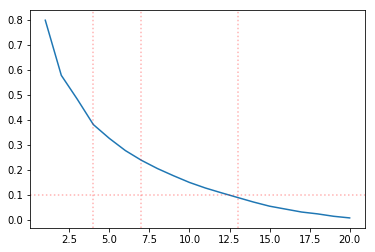

In [16]:
plt.plot(range(1, data.shape[1]), e)
plt.axhline(y=0.1, color='r', linestyle=':', alpha=0.3)
plt.axvline(x=13, color='r', linestyle=':', alpha=0.3)
plt.axvline(x=4, color='r', linestyle=':', alpha=0.3)
plt.axvline(x=7, color='r', linestyle=':', alpha=0.3)

No clear elbow in this plot. 8 principal components gives ~25% variance from the model.

Determine which components carry more than $\epsilon$ variance

In [17]:
epsilon = 0.005

In [18]:
np.where(pca.explained_variance_ratio_ > epsilon)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),)

Look at $T^2$ and Q values to select threshold values

In [28]:
def plot_q_and_t2(data_s, n_components, t2_thresh=None, q_thresh=None):
    pc = PCA(n_components=n_components)
    pc.fit(data_s)
    qvals = q(data_s, pc)
    t2vals = t2(data_s, pc)
    f, axs= plt.subplots(1, 2)
    axs[0].plot(t2vals, '.')
    axs[0].set_title(r"$T^2$")
    if t2_thresh is not None:
        axs[0].axhline(y=t2_thresh, color='r',
                    alpha=0.3, linestyle=':')
    axs[1].plot(qvals, '.')
    axs[1].set_title(r"Q")
    if q_thresh is not None:
        axs[1].axhline(y=q_thresh, color='r',
                    alpha=0.3, linestyle=':')
    plt.suptitle(f"{n_components} PCs")
    plt.show()

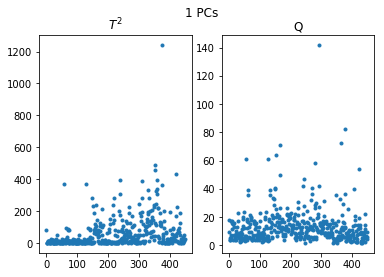

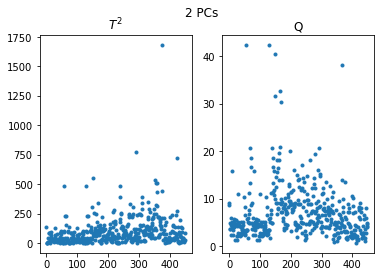

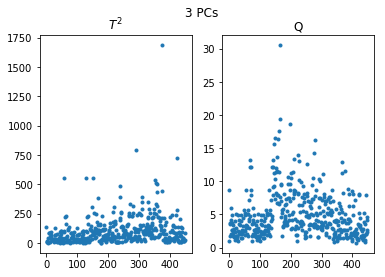

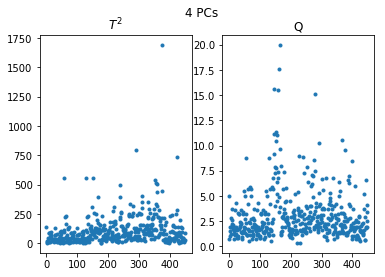

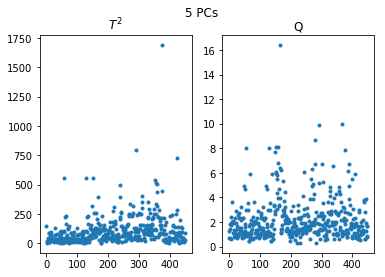

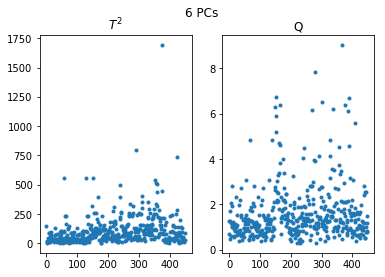

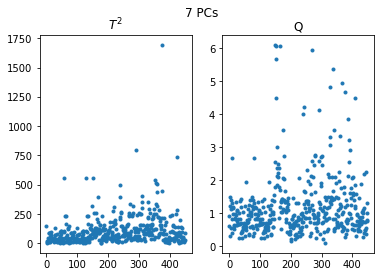

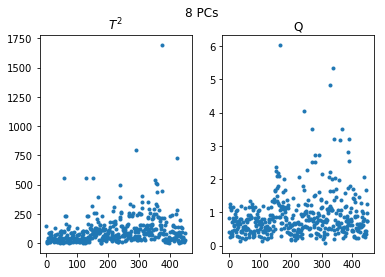

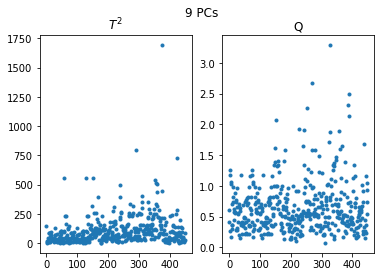

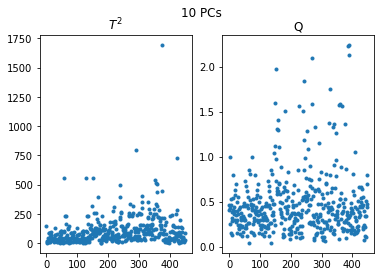

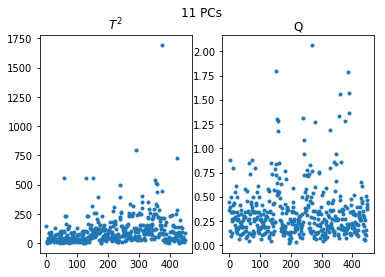

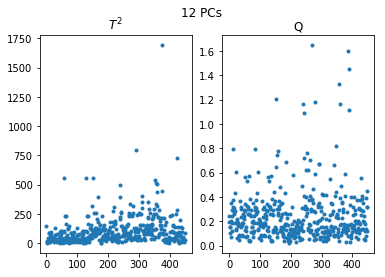

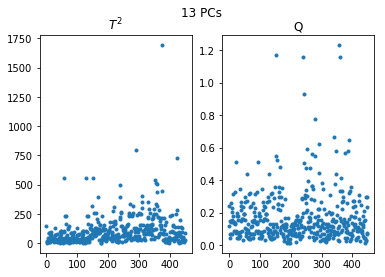

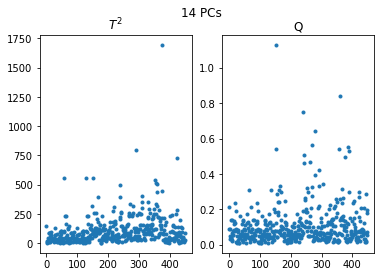

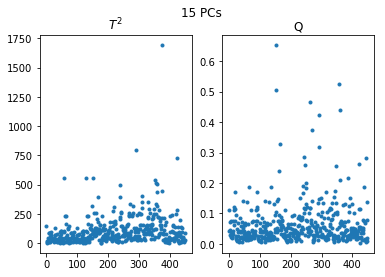

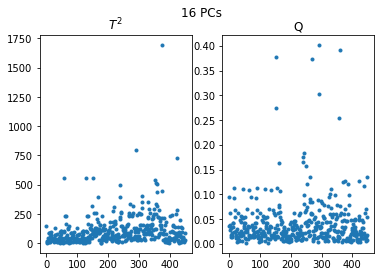

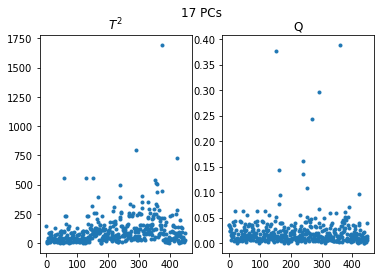

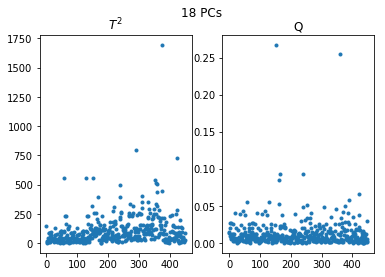

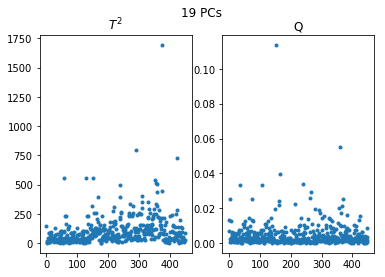

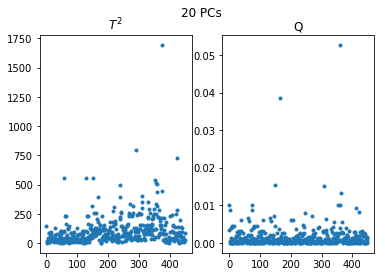

In [29]:
for _ in range(1, data_s.shape[1]):
    plot_q_and_t2(data_s, _)

$T^2$ settles down after 2 PC's. $Q$ (as expected) continues to lower as number of PC's increases (since more of the data is captured in the model). Based on the plots above I have selected 8 PC's

In [21]:
pca = PCA(n_components=8)
pca.fit(data_s)

PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Now set the $T^2$ and $Q$ thresholds at the 95% quantile

In [22]:
t2_data = t2(data_s, pca)

In [23]:
t2_thresh = np.quantile(t2_data, 0.95)

305.4530916663796

In [25]:
q_data = q(data_s, pca)

In [26]:
q_thresh = np.quantile(q_data, 0.95)

2.08084551186551

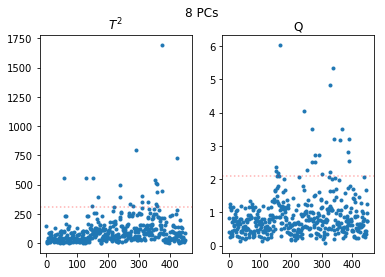

In [30]:
plot_q_and_t2(data_s, 8, t2_thresh=np.quantile(t2_data, 0.95),
              q_thresh=np.quantile(q_data, 0.95))